## Similaridade de Projetos Baseado nos itens utilizados

Lendo os dados e salvando na matriz X.
As features utilizadas neste projeto são: 
- IdPRONAC
- Item
- Quantidade(Proposta)
- Ocorrencia(Proposta)
- QtdeDias(Proposta)
- ValorUnitario(Proposta)
- Justificativa(Proposta)


In [1]:
import pandas as pd
import numpy as np

Data = pd.read_csv('Salic_Data.csv')
Data.columns = ['IdPRONAC', 'CgcCpf', 'AnoProjeto', 'Sequencial', 'idPlanilhaEtapa', 'UF', 'Municipio', 'Item', 'Unidade', 'Quantidade(Proposta)', 'Ocorrencia(Proposta)', 'QtdeDias(Proposta)', 'ValorUnitario(Proposta)', 'Justificativa(Proposta)', 'Quantidade(Projeto)', 'Ocorrencia(Projeto)', 'QtdeDias(Projeto)', 'ValorUnitario(Projeto)', 'Justificativa(Parecista)', 'Produto']

X = Data[['IdPRONAC', 'Item', 'Quantidade(Proposta)', 'Ocorrencia(Proposta)', 'QtdeDias(Proposta)', 'ValorUnitario(Proposta)', 'Justificativa(Proposta)', 'Produto']]

Variáveis úteis utilizadas ao longo do projeto

- ConjuntoDeItens    = conjunto de itens utilizados em todos os projetos.
- ConjuntoDeProjetos = lista do pronac de todos os projetos.
- featureNameToIndex = usado para converter o nome da coluna para o índex da matriz associado.

In [2]:
# FEATURE INDICES
featureNameToIndex = {featureName: index for index, featureName in enumerate(X)}




Indices_Manutencao_de_Museu  = X['Produto'] == 'Exposição de Artes'
Indices_Apresentacao_Musical = X['Produto'] == 'Apresentação Musical'

X_Selected = X[Indices_Manutencao_de_Museu | Indices_Apresentacao_Musical]


ConjuntoDeItens = list(set(X_Selected['Item']))
ConjuntoDeProjetos = list(set(X_Selected['IdPRONAC']))


####  Processamento de dados.

Agrupamento dos itens de cada projeto, considerando também a quantidade.

Criando um dicionário **pronac_itens_dict**

- Key   ->   pronac
- Value -> [item, quantidade] 

In [3]:
from collections import defaultdict
pronac_itens_dict = defaultdict(list)
X_values = X.values

for index, item  in enumerate(X_values):
    pronac_itens_dict[item[featureNameToIndex['IdPRONAC']]].append([item[featureNameToIndex['Item']], item[featureNameToIndex['Quantidade(Proposta)']]*item[featureNameToIndex['Ocorrencia(Proposta)']]*item[featureNameToIndex['QtdeDias(Proposta)']]])

#### Une itens similares e soma quantidade.
- Key   ->   pronac
- Value -> Dicionário{item, quantidade}  

In [4]:
pronac_itens_compressed_dict = {}
for key_pronac, value_itens in pronac_itens_dict.items():
    item_value_dict = {}
    for value in value_itens:
        if value[0] in item_value_dict:
            item_value_dict[value[0]] = item_value_dict[value[0]] + value[1]
        else:
            item_value_dict[value[0]] = value[1]
#     print(key_pronac)
#     print(item_value_dict)
    pronac_itens_compressed_dict[key_pronac] = item_value_dict

#### Criando matriz com todos os dados

    | Pronac 1 | Pronac 2 | Pronac 3 |
        
    |  Item 1  |  Item 1  |  Item 1  |
    |  Item 2  |  Item 2  |  Item 2  |
    |  Item 3  |  Item 3  |  Item 3  |
    ...
    


### Generating Labels

In [36]:
def buildProjetItemsArray(projectItems, allItems):
    items_arrays = np.zeros(len(allItems))
    for index, item in enumerate(allItems):
        if (item in projectItems):
            items_arrays[index] = 1
    return list(items_arrays)

def buildNormalizedProjetItemsArray(projectItems, allItems):
    items_arrays = np.zeros(len(allItems))
    for index, item in enumerate(allItems):
        if (item in projectItems):
            items_arrays[index] = 1
    #print(items_arrays)
    #items_arrays = items_arrays / sum(items_arrays)
    items_arrays = items_arrays / (sum( (item**2) for item in items_arrays))**0.5
    #print(items_arrays)
    return list(items_arrays)
            

projectsItemsMatrix = []
projectKind = []
for index, pronacID in enumerate(ConjuntoDeProjetos):  
    x = buildNormalizedProjetItemsArray(pronac_itens_compressed_dict[pronacID],ConjuntoDeItens)
    projectsItemsMatrix.append(x)
    
    projectType = X_Selected[X_Selected['IdPRONAC'] == pronacID]['Produto'].values == X_Selected['Produto'].values[0]
    projectKind.append(projectType[0])

# #     # Using less data to train faster  
    if (index == 500):
        break;

## Computing SVD

In [ ]:
# U, s, V = np.linalg.svd(projectsItemsMatrix, full_matrices=True) 
# print(s)

### Plotting Data

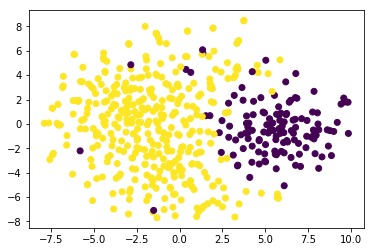

In [37]:
X = projectsItemsMatrix

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=70, n_components=2, n_iter=1000, random_state=8)
y_tsne = tsne_model.fit_transform(X)

plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=projectKind, cmap='viridis')

plt.show();

### Supervised Algorithms

In [38]:
X = projectsItemsMatrix
Y = projectKind

X = np.array(X)
Y = np.array(Y)

# from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from  sklearn.naive_bayes import MultinomialNB
from  sklearn.naive_bayes import BernoulliNB
from  sklearn.linear_model import LogisticRegression



from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import itertools

kf = KFold(n_splits=10, shuffle=True, random_state=5)
kf.get_n_splits(X)

total_confusion_matrix = [[0, 0], [0, 0]]
#    CONFUSION MATRIX 
#    ----------------
#         0  1  2   <- Predicted
#      0 [2, 0, 0]  
# TRUE 1 [0, 0, 1]  
#      2 [1, 0, 2] 

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]


    #classifier = RandomForestClassifier(n_estimators=10, class_weight='balanced') # KNeighborsClassifier()
    classifier = LogisticRegression(class_weight='balanced')
    y_pred = classifier.fit(X_train, y_train).predict(X_test)

#     print(y_pred)
#     print(y_test)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    # print(cnf_matrix)
    total_confusion_matrix = total_confusion_matrix + cnf_matrix

    #print(cnf_matrix, flush=True)
print(total_confusion_matrix, flush=True)
print('Accuracy: ', (total_confusion_matrix[0][0] + total_confusion_matrix[1][1]) / sum(sum(total_confusion_matrix)))



[[122   8]
 [ 10 361]]
Accuracy:  0.964071856287


### Plotting Classified Data

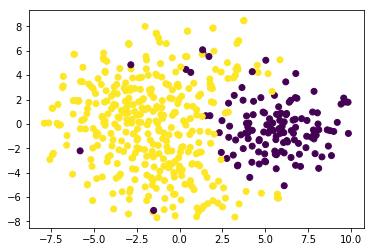

In [42]:
X = projectsItemsMatrix

y_pred = classifier.predict(X)

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=70, n_components=2, n_iter=1000, random_state=8)
y_tsne = tsne_model.fit_transform(X)

plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=y_pred, cmap='viridis')

plt.show();

### Cluster center VS Supervised Algorithm center

In [43]:
X = projectsItemsMatrix
X = np.array(X)

labeled_data = classifier.predict(X)

cluster1 = X[(labeled_data == True)]
cluster2 = X[(labeled_data == False)]

#cluster1[1, :] + cluster1[2, :]

# num_of_entries_cluster_1 = len(cluster1)
# num_of_entries_cluster_2 = len(cluster2)

cluster_1_sum = sum(cluster1[i, :]  for i in range(len(cluster1)) )
cluster_1_normalized = cluster_1_sum / (sum( (item**2) for item in cluster_1_sum))**0.5

cluster_2_sum = sum(cluster2[i, :]  for i in range(len(cluster2)) )
cluster_2_normalized = cluster_2_sum / (sum( (item**2) for item in cluster_2_sum))**0.5

#cluster_1_normalized

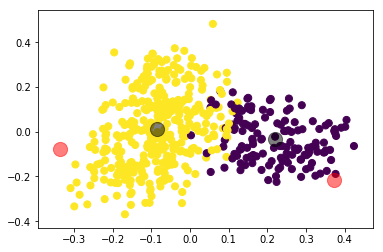

In [44]:
X = projectsItemsMatrix

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=8)  # random_state: 2, 5, *8*
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
kmeans_centers = kmeans.cluster_centers_

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
y_pca = pca.transform(X) 
#y_pca = pca.fit_transform(X)

plt.scatter(y_pca[:, 0], y_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')


centers_pca = pca.transform(kmeans_centers)



supervised_centers_pca_1 = pca.transform([cluster_1_normalized])
supervised_centers_pca_2 = pca.transform([cluster_2_normalized])

plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, alpha=0.5);
plt.scatter(supervised_centers_pca_1[:, 0], supervised_centers_pca_1[:, 1], c='red', s=200, alpha=0.5);
plt.scatter(supervised_centers_pca_2[:, 0], supervised_centers_pca_2[:, 1], c='red', s=200, alpha=0.5);

plt.show();

### Comparing cluster with supervised algorithm

correct predictions:  474
wrong predictions:  27


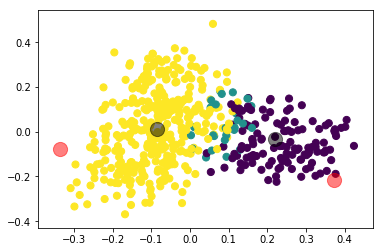

In [40]:
X = projectsItemsMatrix

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=8)  # random_state: 2, 5, *8*
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
kmeans_centers = kmeans.cluster_centers_

y_classifier = classifier.predict(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
cluster_pca = pca.transform(X) 


kmeans_classifier_output = [x+y for (x,y) in zip(y_kmeans, y_classifier)]
#print(y_kmeans)
#print(y_classifier)
#print(kmeans_classifier_output)

correct_predictions = sum([x==y for (x,y) in zip(y_kmeans, y_classifier)])
print('correct predictions: ',correct_predictions)
wrong_predictions = sum([not x==y for (x,y) in zip(y_kmeans, y_classifier)])
print('wrong predictions: ',wrong_predictions)

plt.scatter(y_pca[:, 0], y_pca[:, 1], c=kmeans_classifier_output, s=50, cmap='viridis')


centers_pca = pca.transform(kmeans_centers)



supervised_centers_pca_1 = pca.transform([cluster_1_normalized])
supervised_centers_pca_2 = pca.transform([cluster_2_normalized])

plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, alpha=0.5);
plt.scatter(supervised_centers_pca_1[:, 0], supervised_centers_pca_1[:, 1], c='red', s=200, alpha=0.5);
plt.scatter(supervised_centers_pca_2[:, 0], supervised_centers_pca_2[:, 1], c='red', s=200, alpha=0.5);

plt.show();

### Comparing cluster with data

correct predictions:  472
wrong predictions:  29
"Accuracy":  0.942115768463


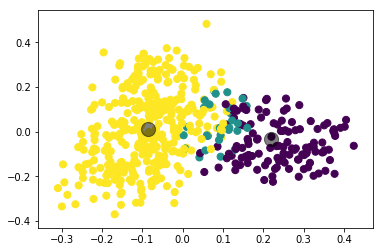

In [47]:
X = projectsItemsMatrix
Y = projectKind

X = np.array(X)
Y = np.array(Y)



import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=8)  # random_state: 2, 5, *8*
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
kmeans_centers = kmeans.cluster_centers_

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X) 


kmeans_label_output = [x+y for (x,y) in zip(y_kmeans, Y)]
#print(y_kmeans)
#print(y_classifier)
#print(kmeans_classifier_output)
correct_predictions = sum([x==y for (x,y) in zip(y_kmeans, Y)])
print('correct predictions: ',correct_predictions)
wrong_predictions = sum([not x==y for (x,y) in zip(y_kmeans, Y)])
print('wrong predictions: ',wrong_predictions)
print('"Accuracy": ',correct_predictions / (correct_predictions+wrong_predictions))

plt.scatter(x_pca[:, 0], x_pca[:, 1], c=kmeans_label_output, s=50, cmap='viridis')


centers_pca = pca.transform(kmeans_centers)


plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, alpha=0.5);

plt.show();

## Normalized VS Non-normalized label vectors


| Algorithm              | Normalized Accuracy (1) |Normalized Accuracy (2) | Non-Normalized Accuracy |
|------------------------|:-----------------------:|:----------------------:|------------------------:|
| KNeighborsClassifier   | 0.948103792415          |                        | 0.766467065868          |
| RandomForestClassifier | 0.942115768463          |                        | 0.930139720559          |
| MultinomialNB          | 0.740518962076          |                        | 0.962075848303          |
| LogisticRegression     | 0.956087824351          |    0.964071856287      | 0.946107784431          |

    
    * Normalized Accuracy (1) --- (L1-norm = 1)
    * Normalized Accuracy (2) --- (L2-norm = 1)
    
    * LogisticRegression --- class_weight='balanced'.
    * MultinomialNB --- cannot balance classes.